# Model v1.3

## Leaderboard score: 1.65591

In [2]:
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, TimeDistributed, Reshape
from keras.layers.advanced_activations import PReLU
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate

In [4]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

In [5]:
import tensorflow as tf
from keras import backend as K

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [7]:
from sklearn_pandas import DataFrameMapper

In [8]:
import pandas as pd
import numpy as np

In [9]:
from keras.utils.np_utils import to_categorical

In [10]:
version = 1.3
version_str = "v" + str(version)

In [11]:
LABEL = "price_doc"

In [12]:
def prepare_dataset(df, test=False, trunc_fields=False):
    global LABEL
    t_fields = ['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor','material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', LABEL]
    
    if not test:
        if trunc_fields:
            df = df[t_fields.append + LABEL]
        else:
            df = df
    else:
        if trunc_fields:
            df = df[t_fields]
        else:
            df = df
    
    df['timestamp_converted'] = pd.to_datetime(df['timestamp'])
    df['timestamp_day'] = df.apply(lambda row: row['timestamp_converted'].day, axis=1)
    df['timestamp_month'] = df.apply(lambda row: row['timestamp_converted'].month, axis=1)
    df['timestamp_year'] = df.apply(lambda row: row['timestamp_converted'].year, axis=1)
    df['state_refractored'] = df.apply( lambda row: 5 if row['state'] == 33 else row['state'] , axis = 1)
    
    df = df.fillna(0)
    
    df['state_refractored'] = df['state_refractored'].astype(int)    
    df['material'] = df['material'].astype(int)    
    return df

In [13]:
final_train_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/final_training_dataset.csv")

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (375,378,379) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
final_train_df = prepare_dataset(final_train_df)

In [15]:
del final_train_df['Unnamed: 0']

In [16]:
final_train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,1,2011-08-20,43,27.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
1,2,2011-08-23,34,19.0,3.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
2,3,2011-08-27,43,29.0,2.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
3,4,2011-09-01,89,50.0,9.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0
4,5,2011-09-05,77,77.0,4.0,0.0,0,0.0,0.0,0.0,...,271.0,6943.0,565.0,0.45356,1240.0,269768.0,22.37,64.12,23587.0,230310.0


## Data prep

In [17]:
def dedup(listy):
    return list(set(listy))

In [18]:
property_columns = [
    # Place features
 'full_sq',
 'kitch_sq',
 'floor',
 'life_sq',
 'build_year',
 'num_room',
 'max_floor',
 'sub_area',
]

time_columns = [
 'timestamp_day',
 'timestamp_month',
 'timestamp_year',
]

population_columns = [
    # Economy: Population
    'male_f',
    'female_f',
    'young_all',
    'young_male',
    'young_female',
    'work_all',
    'work_male',
    'work_female',
    'ekder_all',
    'ekder_male',
    'ekder_female',
    
    'marriages_per_1000_cap',
    'divorce_rate',
    'pop_natural_increase',
    'pop_migration',
    'pop_total_inc',
    'childbirth',
    'mortality',
    'average_life_exp',
]

locality_columns = [
 'metro_min_avto',
    
 'railroad_station_avto_min',
    
 'green_part_1000',
 'green_part_1500',
    
     # Raion = number of...
  'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
    
  # Locality features...
 'railroad_km',
 'green_zone_km',
 'kindergarten_km',
 'public_transport_station_km',
 'metro_km_avto',
 'park_km',
 'cemetery_km',
 'mosque_km',
 'public_healthcare_km',
 'catering_km',
 'big_road2_km',
 'hospice_morgue_km',
 'swim_pool_km',
 'water_treatment_km',
 'power_transmission_line_km',
 'water_km',
 'school_km',
 'ttk_km',
 'area_m',
 'ts_km',
 'university_km',
 'oil_chemistry_km',
 'exhibition_km',
 'shopping_centers_km',
 'zd_vokzaly_avto_km',
 'preschool_km',
 'big_road1_km',
 'additional_education_km',
 'church_synagogue_km',
 'big_church_km',
 'incineration_km',
 'industrial_km',
 'nuclear_reactor_km',
]

economy_columns = [
    
    
     'usdrub',
 'micex_cbi_tr',
 'brent', 
    
     'micex',
    
    'oil_urals',
     
 # Economy features
 'gdp_quart',
 'gdp_quart_growth',
 'cpi',
    'ppi',
    'gdp_deflator',
    'gdp_annual',
    'gdp_annual_growth',
    'average_provision_of_build_contract',
    'average_provision_of_build_contract_moscow',
    'rts',
    'deposits_value',
    'deposits_growth',
    'deposits_rate',
    'mortgage_value',
    'mortgage_growth',
    'mortgage_rate',
    'grp',
    'grp_growth',
    'income_per_cap',
    'real_dispos_income_per_cap_growth',
    'salary',
    'salary_growth',
    'labor_force',
    'unemployment',
    'employment',
    'construction_value',
    'housing_fund_sqm',
    'lodging_sqm_per_cap',
    'water_pipes_share',
    'baths_share',
    'sewerage_share',
    'gas_share',
    'hot_water_share',
    'electric_stove_share',
    'heating_share',
    'old_house_share',
    'incidence_population',
    'rent_price_4+room_bus',
    'rent_price_3room_bus',
    'rent_price_2room_bus',
    'rent_price_1room_bus',
    'rent_price_3room_eco',
    'rent_price_2room_eco',
    'rent_price_1room_eco',
    'apartment_build',
    'apartment_fund_sqm',
    'indust_part',
]

one_hot_cols = [
    'material',
    'state_refractored'
]

columns = dedup(property_columns + population_columns + economy_columns + locality_columns + time_columns + one_hot_cols)

label_cols = [
    'sub_area',
    'big_market_raion',
    'nuclear_reactor_raion',
    'thermal_power_plant_raion',
    'detention_facility_raion',
    'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'full_all',
  'shopping_centers_raion',
  'office_raion',
  'thermal_power_plant_raion',
  'healthcare_centers_raion',
  'university_top_20_raion',
]

exclude_normalize_columns = [
    # Specific columns to exclude...
] + one_hot_cols + label_cols

normalize_columns = [c for c in columns if c not in exclude_normalize_columns]

#locality_columns = [c for c in columns if "_km" in c]
continuous_columns = [c for c in columns if c not in one_hot_cols and c not in label_cols]
continuous_columns_without_locality = [c for c in continuous_columns if c not in locality_columns]

In [19]:
final_train_df = final_train_df[columns + [LABEL]]

In [20]:
final_train_df.head()

,micex_cbi_tr,unemployment,apartment_build,railroad_station_avto_min,rts,pop_migration,work_all,state_refractored,healthcare_centers_raion,max_floor,...,electric_stove_share,salary,cpi,rent_price_4+room_bus,micex,rent_price_3room_bus,average_provision_of_build_contract_moscow,average_life_exp,marriages_per_1000_cap,price_doc
0,204.78,0.014,23587.0,6.905893,1575.33,5.1,98207,0,1,0.0,...,55.3,44898.7,354.0,136.11,1438.74,77.93,6.74,75.79,8.5,5850000
1,204.92,0.014,23587.0,4.679745,1578.91,5.1,70194,0,1,0.0,...,55.3,44898.7,354.0,136.11,1444.11,77.93,6.74,75.79,8.5,6000000
2,204.84,0.014,23587.0,1.701420,1596.17,5.1,63388,0,1,0.0,...,55.3,44898.7,354.0,136.11,1458.84,77.93,6.74,75.79,8.5,5700000
3,205.42,0.014,23587.0,5.271136,1703.86,5.1,120381,0,1,0.0,...,55.3,44898.7,353.2,155.22,1551.58,94.02,6.74,75.79,8.5,13100000
4,198.24,0.014,23587.0,2.156284,1617.01,5.1,68043,0,4,0.0,...,55.3,44898.7,353.2,155.22,1492.83,94.02,6.74,75.79,8.5,16331452


In [21]:
final_train_df = final_train_df.convert_objects(convert_numeric=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


## Prepare numeric data scalers & normalizers

In [22]:
norm_scalers = {column : preprocessing.StandardScaler() for column in normalize_columns}

In [23]:
norm_scalers

{'additional_education_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_build': StandardScaler(copy=True, with_mean=True, with_std=True),
 'apartment_fund_sqm': StandardScaler(copy=True, with_mean=True, with_std=True),
 'area_m': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_life_exp': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract': StandardScaler(copy=True, with_mean=True, with_std=True),
 'average_provision_of_build_contract_moscow': StandardScaler(copy=True, with_mean=True, with_std=True),
 'baths_share': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_church_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road1_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'big_road2_km': StandardScaler(copy=True, with_mean=True, with_std=True),
 'brent': StandardScaler(copy=True, with_mean=True, with_std=True),
 'build_year': StandardScaler(copy=T

In [24]:
len(norm_scalers)

118

In [25]:
ont_hot_scalers = {column : (preprocessing.LabelEncoder(), preprocessing.OneHotEncoder(sparse=False)) for column in one_hot_cols}

In [26]:
ont_hot_scalers

{'material': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False)),
 'state_refractored': (LabelEncoder(),
  OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
         handle_unknown='error', n_values='auto', sparse=False))}

In [27]:
label_scalers = {column : preprocessing.LabelEncoder() for column in label_cols}

In [28]:
label_scalers

{'big_market_raion': LabelEncoder(),
 'detention_facility_raion': LabelEncoder(),
 'full_all': LabelEncoder(),
 'healthcare_centers_raion': LabelEncoder(),
 'nuclear_reactor_raion': LabelEncoder(),
 'office_raion': LabelEncoder(),
 'shopping_centers_raion': LabelEncoder(),
 'sub_area': LabelEncoder(),
 'thermal_power_plant_raion': LabelEncoder(),
 'university_top_20_raion': LabelEncoder()}

In [29]:
for column in normalize_columns:
    c_scaler = norm_scalers[column]
    try:
        c_scaler.fit(final_train_df[[column]].values)
    except:
        print 'failed: ', column

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [30]:
for column in one_hot_cols:
    label_enc, one_hot_enc = ont_hot_scalers[column]
    r = label_enc.fit_transform(final_train_df[[column]].values)
    r = np.expand_dims(r, axis=1)
    one_hot_enc.fit(r)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
for column in label_cols:
    label_enc = label_scalers[column]
    label_enc.fit(final_train_df[[column]].values)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Test the scalers...

In [32]:
norm_scalers['timestamp_day'].transform([final_train_df.ix[0]['timestamp_day']])

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


array([ 0.40933319])

In [33]:
ont_hot_scalers['material'][1].transform([final_train_df.ix[70]['material']])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [34]:
label_scalers['sub_area'].transform([final_train_df.ix[0]['sub_area']])

array([9])

In [35]:
sub_area_metadata = open('/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv', 'w+')
sub_area_metadata.write("Sub area\n" + "\n".join([label_scalers['sub_area'].inverse_transform([i])[0] for i in range(146)]))
sub_area_metadata.close()

### Save them to disk

In [36]:
from sklearn.externals import joblib

In [37]:
joblib.dump(norm_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/norm_scalers.pkl']

In [38]:
joblib.dump(ont_hot_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/one_hot_scalers.pkl']

In [39]:
joblib.dump(label_scalers, '/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl') 

['/mnt/h/Kaggle/Competitions/Russian Bank/code/data/label_scalers.pkl']

### Transform the whole training data

In [40]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_train_df[[continuous_norm_col]].values)
    final_train_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [41]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_train_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_train_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_train_df[[label_col]].values)
    final_train_df[label_col + "_scaled_feature"] = encoded_values

In [43]:
def extract_normalized_feature(df, feature_name):
    return np.array(df[feature_name + "_scaled_feature"].values.tolist())

In [44]:
extract_normalized_feature(final_train_df, "full_sq")

array([-0.29487286, -0.53152276, -0.29487286, ..., -0.24228399,
        0.25731024, -0.29487286])

In [45]:
extract_normalized_feature(final_train_df, "life_sq")

array([-0.00404841, -0.16882931,  0.03714682, ..., -0.56018395,
        0.09893965,  0.0165492 ])

In [46]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [47]:
locality_columns[0], extract_normalized_feature(final_train_df, locality_columns[0])

('metro_min_avto',
 array([-0.36180133, -0.61411914, -0.43340412, ..., -0.42855279,
        -0.24162376, -0.66784139]))

In [48]:
extract_normalized_feature(final_train_df, "sub_area")

array([  9,  70, 129, ..., 103,  77,  75])

In [49]:
def extract_temporal_features(df):
    global time_columns
    vals = []
    for c in time_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [50]:
def extract_property_place_features(df):
    global property_columns
    vals = []
    for c in property_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [51]:
def extract_economy_features(df):
    global economy_columns
    vals = []
    for c in economy_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [52]:
def extract_population_features(df):
    global population_columns
    vals = []
    for c in population_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [53]:
def extract_locality_features(df):
    global locality_columns
    vals = []
    for c in locality_columns:
        vals.append(extract_normalized_feature(df, c).reshape(-1, 1))
    return np.hstack(tuple(vals))

In [54]:
def extract_categorical_features(df):
    global one_hot_cols, label_cols
    vals = {}
    for c in one_hot_cols + label_cols:
        vals[c]  = extract_normalized_feature(df, c)
    return vals

In [56]:
#extract_continuous_features(final_train_df).shape # 51 + 3 (one hot columns) + 1 (label) = 55 (total dataframe columns excluding id)...

In [57]:
extract_locality_features(final_train_df).shape

(30471, 46)

In [58]:
extract_categorical_features(final_train_df)

{'big_market_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'detention_facility_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'full_all': array([78, 59, 89, ..., 18, 73, 54]),
 'healthcare_centers_raion': array([1, 1, 1, ..., 0, 2, 2]),
 'material': array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]]),
 'nuclear_reactor_raion': array([0, 0, 0, ..., 0, 0, 0]),
 'office_raion': array([1, 0, 1, ..., 0, 5, 1]),
 'shopping_centers_raion': array([13,  3,  0, ...,  1,  4,  5]),
 'state_refractored': array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.],
        ..., 
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.]]),
 'sub_area': array([  9,  7

In [59]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2):
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test

In [60]:
train_split_df, test_split_df = train_test_split(final_train_df, test_size = 0.1)

In [61]:
train_split_df_temporal_features = extract_temporal_features(train_split_df)
test_split_df_temporal_features = extract_temporal_features(test_split_df)

In [62]:
train_split_df_property_features = extract_property_place_features(train_split_df)
test_split_df_property_features = extract_property_place_features(test_split_df)

In [63]:
train_split_df_locality_features = extract_locality_features(train_split_df)
test_split_df_locality_features = extract_locality_features(test_split_df)

In [64]:
train_split_df_economy_features = extract_economy_features(train_split_df)
test_split_df_economy_features = extract_economy_features(test_split_df)

In [65]:
train_split_df_population_features = extract_population_features(train_split_df)
test_split_df_population_features = extract_population_features(test_split_df)

In [66]:
train_split_df_categorical_features = extract_categorical_features(train_split_df)
test_split_df_categorical_features = extract_categorical_features(test_split_df)

In [67]:
def format_input(df):
    temporal_features = extract_temporal_features(df)
    property_features = extract_property_place_features(df)
    locality_features = extract_locality_features(df)
    economy_features = extract_economy_features(df)
    population_features = extract_population_features(df)
    categorical_features = extract_categorical_features(df)
    return temporal_features, property_features, locality_features, economy_features, population_features, categorical_features

## Model

In [68]:
def temporal_submodel(num_temporal_features, dropout=0.25):
    with tf.name_scope("temporal_submodel"):
        temporal_model = Sequential()
        temporal_model.add(Dense(64, input_shape=(num_temporal_features,)))
        temporal_model.add(BatchNormalization())
        temporal_model.add(PReLU())
        return temporal_model  

In [69]:
def locality_submodel(num_locality_features, hidden_units=[512, 256, 128, 64], dropout=0.25):
    """
    This submodel processess the locality-based features for a given place (eg. nearest subway in kilometers, etc.)
    """
    with tf.name_scope("locality_submodel"):
        locality_model = Sequential()
        for index, hidden_unit in enumerate(hidden_units):
            if index == 0:
                locality_model.add(Dense(hidden_unit, input_shape=(num_locality_features,)))
                locality_model.add(BatchNormalization())
                locality_model.add(PReLU())
            else:
                locality_model.add(Dense(hidden_unit))
                locality_model.add(BatchNormalization())
                locality_model.add(PReLU())
        #locality_model.add(Dropout(dropout))
        return locality_model

In [70]:
def economy_submodel(num_economy_features, hidden_units=[512, 256, 128, 64], dropout=0.25):
    """
    This submodel processess the economy-based features at a given time (eg. unemployment rate, etc.)
    """
    with tf.name_scope("economy_submodel"):
        economy_model = Sequential()
        
        for index, hidden_unit in enumerate(hidden_units):
            if index == 0:
                economy_model.add(Dense(hidden_unit, input_shape=(num_economy_features,)))
                economy_model.add(BatchNormalization())
                economy_model.add(PReLU())
            else:
                economy_model.add(Dense(hidden_unit))
                economy_model.add(BatchNormalization())
                economy_model.add(PReLU())
        return economy_model

In [71]:
def population_submodel(num_population_features, hidden_units=[128, 64], dropout=0.25):
    with tf.name_scope("population_submodel"):
        population_model = Sequential()
        for index, hidden_unit in enumerate(hidden_units):
            if index == 0:
                population_model.add(Dense(hidden_unit, input_shape=(num_population_features,)))
                population_model.add(BatchNormalization())
                population_model.add(PReLU())
            else:
                population_model.add(Dense(hidden_unit))
                population_model.add(BatchNormalization())
                population_model.add(PReLU())
        return population_model

In [72]:
def property_submodel(num_property_features, hidden_units=[128, 64], dropout=0.25):
    with tf.name_scope("property_submodel"):
        property_model = Sequential()
        for index, hidden_unit in enumerate(hidden_units):
            if index == 0:
                property_model.add(Dense(hidden_unit, input_shape=(num_property_features,)))
                property_model.add(BatchNormalization())
                property_model.add(PReLU())
            else:
                property_model.add(Dense(hidden_unit))
                property_model.add(BatchNormalization())
                property_model.add(PReLU())
        return property_model

In [73]:
"""
The main model, version: 0
""" 
def main_model_v1(cat_num_classes={}, output_activation='relu'):
    
    with tf.name_scope("house_price_model"):
    
        # Constants
        num_locality_features = len(locality_columns)
        num_economy_features = len(economy_columns)
        num_population_features = len(population_columns)
        num_property_features = len(property_columns)
        num_temporal_features = len(time_columns)
        num_material_classes = cat_num_classes["material"]
        num_state_classes = cat_num_classes['state']
        
        # Inputs
        with tf.name_scope("inputs"):
            ## Continuous
            time_input = Input(shape=(num_temporal_features,), name="temporal_input")
            property_input = Input(shape=(num_property_features,), name='property_input')
            locality_input = Input(shape=(num_locality_features,), name='locality_input')
            economy_input = Input(shape=(num_economy_features,), name="economy_input")
            population_input = Input(shape=(num_population_features,), name="population_input")
            ## Categorical (one-hot encoding; not using embeddings cuz number of classes is very small, but maybe should try later???)
            material_input = Input(shape=(num_material_classes,), name='material_input')
            state_input = Input(shape=(num_state_classes,), name='state_input')
            ## Categorical (labelled)
            sub_area_input = Input(shape=(1,), dtype='int32', name='sub_area_input')
            sub_area_vocab_size = 200 # It's actually 146, but rounding it to 200
            sub_area_embedding_dim = 8
            
        with tf.name_scope("sub_area_embedding"):
            # Network
            ## Embedding
            sub_area_vector = Embedding(output_dim=sub_area_embedding_dim, input_dim=sub_area_vocab_size, input_length=1, name="sub_area_embedding")(sub_area_input)
            sub_area_vector = TimeDistributed(Dense(64, activation='relu'))(sub_area_vector)
            sub_area_vector = Reshape((64,))(sub_area_vector)
            
        with tf.name_scope("temporal_network"):
            temporal_model = temporal_submodel(num_temporal_features=num_temporal_features)
            time_vector = temporal_model(time_input)
           # time_output = Dense(1, activation='relu', name="time_output")(time_vector)
            
        with tf.name_scope("property_network"):
            ## Map continuous input features into network
            property_model = property_submodel(num_property_features=num_property_features)
            property_vector = property_model(property_input)
           # property_output = Dense(1, activation='relu', name="property_output")(property_vector)
            
        with tf.name_scope("locality_network"):
            ## Map locality based input features into network via submodel
            locality_model = locality_submodel(num_locality_features=num_locality_features)
            locality_vector = locality_model(locality_input)
           # locality_output = Dense(1, activation='relu', name="locality_output")(locality_vector)
            
        with tf.name_scope("economy_network"):
            ## Map continuous input features into network
            economy_model = economy_submodel(num_economy_features=num_economy_features)
            economy_vector = economy_model(economy_input)
           # economy_output = Dense(1, activation='relu', name="economy_output")(economy_vector)
            
        with tf.name_scope("population_network"):
            ## Map continuous input features into network
            population_model = population_submodel(num_population_features=num_population_features)
            population_vector = population_model(population_input)
           # population_output = Dense(1, activation='relu', name="population_output")(population_vector)
            
        with tf.name_scope("material_network"):
            ## Map material input feature into network
            material_vector = Dense(128)(material_input)
            material_vector = PReLU()(material_vector)
            material_vector = Dropout(0.2)(material_vector)
            material_vector = Dense(64)(material_vector)
            material_vector = PReLU()(material_vector)
            
        with tf.name_scope("state_network"): 
            ## Map state input feature into network
            state_vector = Dense(128)(state_input)
            state_vector = PReLU()(state_vector)
            state_vector = Dropout(0.2)(state_vector)
            state_vector = Dense(64)(state_vector)
            state_vector = PReLU()(state_vector)
            
        with tf.name_scope("merge_layer"):
            ## Concatenate all suboutput vectors into one big vector
            merged_output_vector = Concatenate()([time_vector, property_vector, locality_vector, economy_vector, population_vector, material_vector, state_vector, sub_area_vector])
            merged_output_vector = BatchNormalization()(merged_output_vector) # Batch normalize this combined pre-output vector

            
        with tf.name_scope("fully_connected"):
            ## Some final hidden layers
            merged_output_vector = Dense(1024)(merged_output_vector)
            merged_output_vector = PReLU()(merged_output_vector)
            merged_output_vector = Dropout(0.4)(merged_output_vector)
            merged_output_vector = Dense(512)(merged_output_vector)
            merged_output_vector = PReLU()(merged_output_vector)
            merged_output_vector = Dropout(0.2)(merged_output_vector)
            merged_output_vector = Dense(256)(merged_output_vector)
            merged_output_vector = PReLU()(merged_output_vector)
            merged_output_vector = Dropout(0.2)(merged_output_vector)
            merged_output_vector = Dense(128)(merged_output_vector)
            merged_output_vector = PReLU()(merged_output_vector)
            merged_output_vector = Dropout(0.1)(merged_output_vector)
    
        main_output = Dense(1, activation=output_activation, name="main_output")(merged_output_vector)
        
        return [time_input, property_input, locality_input, economy_input, population_input, material_input, state_input, sub_area_input], main_output

In [74]:
num_classes_material = train_split_df_categorical_features['material'].shape[1]
num_classes_state = train_split_df_categorical_features['state_refractored'].shape[1]

inputs, outputs = main_model_v1({"material" : num_classes_material, "state" : num_classes_state})

real_estate_price_model = Model(inputs=inputs, outputs=outputs)

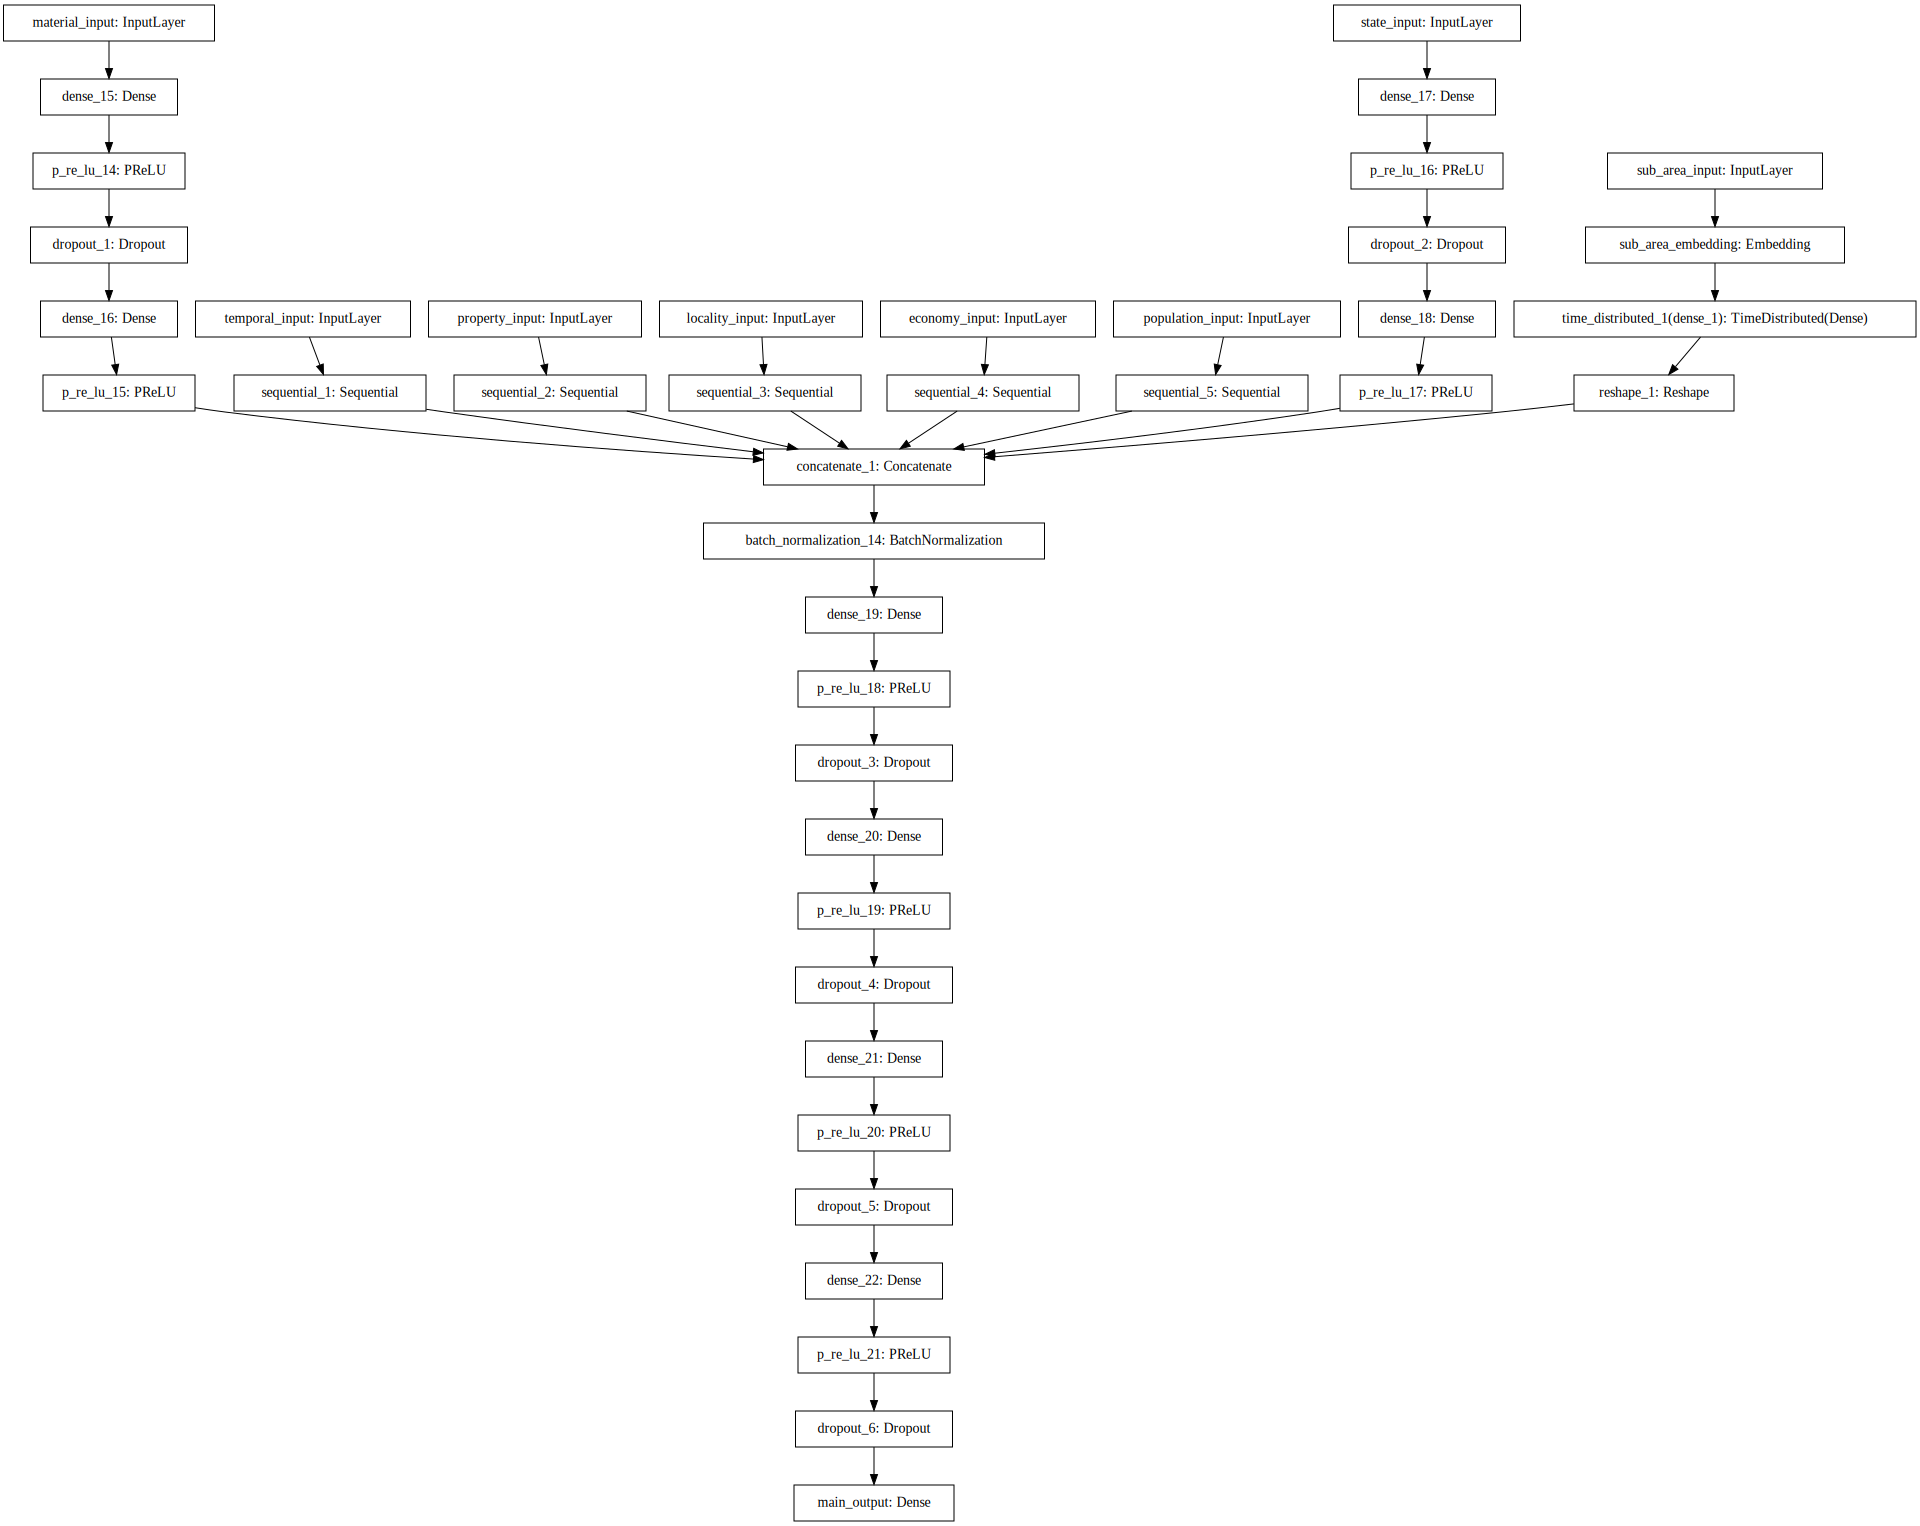

In [75]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot

# Show the model in ipython notebook
SVG(model_to_dot(real_estate_price_model).create(prog='dot', format='svg'))

In [76]:
# Save the model as png file
from keras.utils.vis_utils import plot_model
plot_model(real_estate_price_model, to_file='/mnt/h/Kaggle/Competitions/Russian Bank/models/'+version_str+'/model.png', show_shapes=True)

In [77]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred_log = K.log(y_pred + 1.)
    y_true_log = K.log(y_true + 1.)
    return K.sqrt(K.mean(K.square(y_pred_log - y_true_log), axis = -1))

In [78]:
real_estate_price_model.compile(optimizer = "adam", 
                          loss = root_mean_squared_logarithmic_error
                         )

### Train the model

In [79]:
epochs = 100

In [80]:
checkpointer = ModelCheckpoint(filepath="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/" + "weights.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="/mnt/h/Kaggle/Competitions/Russian Bank/models/" + version_str + "/logs/",
                          histogram_freq=0, 
                          write_graph=True, 
                         # write_grads=True, 
                          write_images=False, 
                          embeddings_freq=5, 
                          embeddings_layer_names=[
                              'sub_area_embedding'
                          ], embeddings_metadata={
                              'sub_area_embedding':'/mnt/h/Kaggle/Competitions/Russian Bank/models/metadata/sub_area_metadata.tsv'
                          })
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
callbacks = [checkpointer, tensorboard, early_stopping]

In [81]:
real_estate_price_model.fit(x={
    'temporal_input' : train_split_df_temporal_features,
    'property_input' : train_split_df_property_features,
    'locality_input' : train_split_df_locality_features,
    'economy_input' : train_split_df_economy_features,
    'population_input' : train_split_df_population_features,
    'state_input' : train_split_df_categorical_features['state_refractored'],
    'material_input' : train_split_df_categorical_features['material'],
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      callbacks=callbacks,
                      verbose = 2,
                      validation_split=0.20,
                      shuffle=True,
                      epochs=epochs)

KeyboardInterrupt: 

In [85]:
real_estate_price_model.load_weights('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/weights.42-0.23.hdf5')

In [86]:
test_loss = real_estate_price_model.evaluate(x={
    'temporal_input' : train_split_df_temporal_features,
    'property_input' : train_split_df_property_features,
    'locality_input' : train_split_df_locality_features,
    'economy_input' : train_split_df_economy_features,
    'population_input' : train_split_df_population_features,
    'state_input' : train_split_df_categorical_features['state_refractored'],
    'material_input' : train_split_df_categorical_features['material'],
    'sub_area_input' : train_split_df_categorical_features['sub_area']},
                      y = train_split_df['price_doc'].values,
                      verbose = 2)
'Test loss: ', test_loss

('Test loss: ', 0.22221496408303371)

In [87]:
test_loss = real_estate_price_model.evaluate(x={
    'temporal_input' : test_split_df_temporal_features,
    'property_input' : test_split_df_property_features,
    'locality_input' : test_split_df_locality_features,
    'economy_input' : test_split_df_economy_features,
    'population_input' : test_split_df_population_features,
    'state_input' : test_split_df_categorical_features['state_refractored'],
    'material_input' : test_split_df_categorical_features['material'],
    'sub_area_input' : test_split_df_categorical_features['sub_area']},
                      y = test_split_df['price_doc'].values,
                      verbose = 2)
'Test loss: ', test_loss

('Test loss: ', 0.21863640793978073)

In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [112]:
seed = 7
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

In [113]:
kfold.get_n_splits(final_train_df, final_train_df[[LABEL]].values)

2

In [114]:
eval_loss_scores = []

for idx, (train, test) in enumerate(kfold.split(final_train_df, final_train_df[[LABEL]].values.ravel())):
    
    temp_x, temp_y = final_train_df.ix[train, :], final_train_df.ix[train, :][LABEL].values
    temp_test_x, temp_test_y = final_train_df.ix[test, :], final_train_df.ix[test, :][LABEL].values
    
    temp_train_split_df_temporal_features = extract_temporal_features(temp_x)
    temp_test_split_df_temporal_features = extract_temporal_features(temp_test_x)
    
    temp_train_split_df_property_features = extract_property_place_features(temp_x)
    temp_test_split_df_property_features = extract_property_place_features(temp_test_x)
    
    temp_train_split_df_locality_features = extract_locality_features(temp_x)
    temp_test_split_df_locality_features = extract_locality_features(temp_test_x)
    
    temp_train_split_df_economy_features = extract_economy_features(temp_x)
    temp_test_split_df_economy_features = extract_economy_features(temp_test_x)
    
    temp_train_split_df_population_features = extract_population_features(temp_x)
    temp_test_split_df_population_features = extract_population_features(temp_test_x)
    
    temp_train_split_df_categorical_features = extract_categorical_features(temp_x)
    temp_test_split_df_categorical_features = extract_categorical_features(temp_test_x)
    
    print 'Cross validating.... step: ', idx
    
    temp_train_loss = real_estate_price_model.evaluate(x={
        'temporal_input' : temp_train_split_df_temporal_features,
        'property_input' : temp_train_split_df_property_features,
        'locality_input' : temp_train_split_df_locality_features,
        'economy_input' : temp_train_split_df_economy_features,
        'population_input' : temp_train_split_df_population_features,
        'state_input' : temp_train_split_df_categorical_features['state_refractored'],
        'material_input' : temp_train_split_df_categorical_features['material'],
        'sub_area_input' : temp_train_split_df_categorical_features['sub_area']},
                      y = temp_y,
                      verbose = 2)
    print 'Temp train loss: ', temp_train_loss, ' index: ', idx
    eval_loss_scores.append(temp_train_loss)
    
    temp_test_loss = real_estate_price_model.evaluate(x={
        'temporal_input' : temp_test_split_df_temporal_features,
        'property_input' : temp_test_split_df_property_features,
        'locality_input' : temp_test_split_df_locality_features,
        'economy_input' : temp_test_split_df_economy_features,
        'population_input' : temp_test_split_df_population_features,
        'state_input' : temp_test_split_df_categorical_features['state_refractored'],
        'material_input' : temp_test_split_df_categorical_features['material'],
        'sub_area_input' : temp_test_split_df_categorical_features['sub_area']},
                      y = temp_test_y,
                      verbose = 2)
    print 'Temp test loss: ', temp_test_loss, ' index: ', idx
    eval_loss_scores.append(temp_test_loss)
    
    
print eval_loss_scores


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Cross validating.... step:  0
Temp train loss:  0.223935881243  index:  0
Temp test loss:  0.219874751205  index:  0
Cross validating.... step:  1
Temp train loss:  0.219874751205  index:  1
Temp test loss:  0.223935881243  index:  1
[0.22393588124323105, 0.21987475120539024, 0.21987475120539024, 0.22393588124323105]


In [115]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(eval_loss_scores), np.std(eval_loss_scores)))

0.22% (+/- 0.00%)


In [116]:
real_estate_price_model.save('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.22_val_loss.h5')

In [117]:
from keras.models import load_model

In [118]:
real_estate_price_model_duplicate = load_model('/mnt/h/Kaggle/Competitions/Russian Bank/models/v'+str(version) + '/trained_model_0.22_val_loss.h5', custom_objects={"root_mean_squared_logarithmic_error":root_mean_squared_logarithmic_error})

In [121]:
test_temporal_features, test_property_features, test_locality_features, test_economy_features, test_population_features, test_categorical_features = format_input(test_split_df[:10])
test_preds = real_estate_price_model_duplicate.predict(x={
    'temporal_input' : test_temporal_features,
    'property_input' : test_property_features,
    'locality_input' : test_locality_features,
    'economy_input' : test_economy_features,
    'population_input' : test_population_features,
    'state_input' : test_categorical_features['state_refractored'],
    'material_input' : test_categorical_features['material'],
    'sub_area_input' : test_categorical_features['sub_area']})
test_actuals = test_split_df[:10].price_doc.values

In [122]:
zip(test_actuals, test_preds.ravel())

[(6200000, 5940329.5),
 (9000000, 9858800.0),
 (3752736, 3800002.5),
 (5850000, 6003214.5),
 (3266912, 3176527.2),
 (7079708, 6007599.0),
 (5500000, 5722229.5),
 (4620233, 4111444.5),
 (8400000, 7828964.0),
 (15850000, 12758972.0)]

In [123]:
kaggle_test = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/test.csv/test.csv")

In [124]:
kaggle_test.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,8,0,0,0,1,10,1,0,14,1
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,4,1,1,0,2,11,0,1,12,1
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,42,11,4,0,10,21,0,10,71,11
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,1,1,2,0,0,10,0,0,2,0
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,5,1,1,0,2,12,0,1,11,1


In [125]:
macro_df = pd.read_csv("/mnt/h/Kaggle/Competitions/Russian Bank/data/macro.csv/macro.csv")

In [126]:
final_kaggle_df = pd.merge(kaggle_test, macro_df, on='timestamp')

In [127]:
final_kaggle_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,30474,2015-07-01,39.0,20.7,2,9,1,1998.0,1,8.9,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
1,30475,2015-07-01,79.2,NaN,8,17,1,0.0,3,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
2,30476,2015-07-01,40.5,25.1,3,5,2,1960.0,2,4.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
3,30477,2015-07-01,62.8,36.0,17,17,1,2016.0,2,62.8,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9
4,30478,2015-07-01,40.0,40.0,17,17,1,0.0,1,1.0,...,NaN,10805.0,NaN,0.45888,NaN,463938.0,NaN,NaN,NaN,234576.9


In [128]:
final_kaggle_df = prepare_dataset(final_kaggle_df)

In [129]:
for continuous_norm_col in normalize_columns:
    scaler = norm_scalers[continuous_norm_col]
    scaled_values = scaler.transform(final_kaggle_df[[continuous_norm_col]].values)
    final_kaggle_df[continuous_norm_col + "_scaled_feature"] = scaled_values

In [130]:
for one_hot_col in one_hot_cols:
    l_scaler = ont_hot_scalers[one_hot_col][0]
    scaler = ont_hot_scalers[one_hot_col][1]
    r = l_scaler.transform(final_kaggle_df[[one_hot_col]].values)
    r = np.expand_dims(r, axis=1)
    scaled_values = scaler.transform(r)
    final_kaggle_df[one_hot_col + "_scaled_feature"] = list(scaled_values)

In [131]:
for label_col in label_cols:
    label_enc = label_scalers[label_col]
    encoded_values = label_enc.transform(final_kaggle_df[[label_col]].values)
    final_kaggle_df[label_col + "_scaled_feature"] = encoded_values

In [132]:
[c for c in final_kaggle_df.columns.tolist() if "_scaled_feature" in c]

['micex_cbi_tr_scaled_feature',
 'unemployment_scaled_feature',
 'apartment_build_scaled_feature',
 'railroad_station_avto_min_scaled_feature',
 'rts_scaled_feature',
 'pop_migration_scaled_feature',
 'work_all_scaled_feature',
 'max_floor_scaled_feature',
 'housing_fund_sqm_scaled_feature',
 'heating_share_scaled_feature',
 'catering_km_scaled_feature',
 'zd_vokzaly_avto_km_scaled_feature',
 'mortality_scaled_feature',
 'water_km_scaled_feature',
 'green_part_1000_scaled_feature',
 'deposits_rate_scaled_feature',
 'park_km_scaled_feature',
 'big_road1_km_scaled_feature',
 'hospice_morgue_km_scaled_feature',
 'metro_km_avto_scaled_feature',
 'ekder_male_scaled_feature',
 'female_f_scaled_feature',
 'deposits_growth_scaled_feature',
 'usdrub_scaled_feature',
 'deposits_value_scaled_feature',
 'gdp_annual_growth_scaled_feature',
 'big_church_km_scaled_feature',
 'exhibition_km_scaled_feature',
 'area_m_scaled_feature',
 'young_male_scaled_feature',
 'ekder_all_scaled_feature',
 'divorce_

In [133]:
kaggle_temporal_features, kaggle_property_features, kaggle_locality_features, kaggle_economy_features, kaggle_population_features, kaggle_categorical_features = format_input(final_kaggle_df)
kaggle_preds = real_estate_price_model.predict(x={
    'temporal_input' : kaggle_temporal_features,
    'property_input' : kaggle_property_features,
    'locality_input' : kaggle_locality_features,
    'economy_input' : kaggle_economy_features,
    'population_input' : kaggle_population_features,
    'state_input' : kaggle_categorical_features['state_refractored'],
    'material_input' : kaggle_categorical_features['material'],
    'sub_area_input' : kaggle_categorical_features['sub_area']})

In [134]:
final_kaggle_df['price_doc'] = kaggle_preds

In [135]:
final_kaggle_df['price_doc']

0        5980774.50
1        8872418.00
2        6303998.50
3        6438242.00
4        5553354.00
5       10193707.00
6        4533308.00
7        3993631.25
8        5263940.50
9        6027741.00
10       6201747.50
11       5373631.50
12       4847195.50
13       4771602.00
14       7559910.50
15       5897097.50
16      22925302.00
17      19785556.00
18       6392773.00
19      16061372.00
20       7623739.50
21      10940440.00
22       8212951.50
23       9520482.00
24       5555577.50
25      10672373.00
26      12706780.00
27       7793685.50
28       3351842.75
29       8073909.50
           ...     
7632    61418112.00
7633    59308260.00
7634    64542184.00
7635    60552920.00
7636    59762240.00
7637    61289656.00
7638    59197656.00
7639    60669584.00
7640    61010928.00
7641    59416784.00
7642    61607088.00
7643    62349140.00
7644    62745964.00
7645    59315360.00
7646    62894176.00
7647    60057056.00
7648    61008092.00
7649    61011548.00
7650    61277440.00


In [136]:
final_kaggle_df[['id', 'price_doc']]

,id,price_doc
0,30474,5980774.50
1,30475,8872418.00
2,30476,6303998.50
3,30477,6438242.00
4,30478,5553354.00
5,30479,10193707.00
6,30480,4533308.00
7,30481,3993631.25
8,30482,5263940.50
9,30483,6027741.00


In [137]:
final_kaggle_df[['id', 'price_doc']].to_csv("/mnt/h/Kaggle/Competitions/Russian Bank/models/v" + str(version) + "/submission.csv", index=False) # output submission csv file